In [6]:
import numpy as np
import pickle
import copy

import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
input_filename='/scratch/gpfs/jabbate/mixed_data/final_data.pkl'
with open(input_filename, 'rb') as f: 
    raw_data=pickle.load(f, encoding='latin1')

In [85]:
from helpers.data_generator import process_data, DataGenerator
parameter_dic_filename='/home/jabbate/run_results/oct_20/model-conv2d_profiles-temp-dens_act-pinj-curr-tinj-target_density_targ-temp_profLB-1_actLB-6_norm-RobustScaler_activ-relu_nshots-12000_ftop-True_21Oct19-00-16_Scenario-496_params.pkl'
with open(parameter_dic_filename,'rb') as f:
    params=pickle.load(f)

In [86]:
signames=['thomson_temp_EFITRT1','thomson_temp_EFIT01','temp']
data=process_data(raw_data,
                  signames,
                  'RobustScaler',
                  window_length=3,
                  window_overlap=1,
                  lookbacks={signame: 1 for signame in signames},
                  lookahead=1,
                  sample_step=1,
                  train_frac=1,
                  val_frac=0)

Signals: temp, thomson_temp_EFIT01, thomson_temp_EFITRT1


Gathering:   0%|          | 0/9852 [00:00<?, ?it/s]/home/jabbate/plasma-profile-predictor/helpers/data_generator.py:300: RuntimeWarning: Mean of empty slice
  return np.nanmean(array[start:start+window_length], axis=0)
Gathering:   0%|          | 2/9852 [00:00<10:59, 14.93it/s]

Number of useable shots:  9852
Number of shots used:  9852
Total number of timesteps:  2616775


Stacking:   0%|          | 0/12 [00:00<?, ?it/s]

Shots with Complete NaN: [156351.], [156352.], [156394.], [156395.], [156396.], [156400.], [156401.], [156402.], [156403.], [156478.], [156479.], [156480.], [156481.], [156482.], [156793.], [156796.], [157744.], [157747.], [158007.], [158008.], [159579.], [160857.], [161125.], [161179.], [164471.], [164473.], [164474.], [165187.], [165343.], [165714.], [165864.], [165885.], [165891.], [166355.], [166428.], [166453.], [167346.], [167599.], [171187.], [171541.], [172008.], [172051.], [172052.], [172053.], [172055.], [172065.], [172066.], [172067.], [172068.], [172069.], [172077.], [172078.], [172079.], [172080.], [172081.], [172083.], [172084.], [172085.], [172090.], [172292.], [172293.], [172294.], [172295.], [172296.], [172297.], [172302.], [173140.], [173145.], [173146.], [173150.], [173718.], [173989.], [174040.], [174041.], [174750.], [174752.], [174755.], [174762.], [175032.], [175033.], [175091.], [175707.], [175708.], [175709.], [175710.], [175711.], [176359.], [176365.], [176367

Removing ECH:   0%|          | 333/250356 [00:00<01:15, 3328.36it/s]

912220 samples total


Removing ECH: 100%|##########| 250356/250356 [01:14<00:00, 3364.32it/s]


Removed 314437 samples
597783 samples remaining


Removing weird gas: 100%|##########| 17313/17313 [00:04<00:00, 4200.73it/s]


Removed 23927 samples
573856 samples remaining


Normalizing:  33%|###3      | 4/12 [00:00<00:00, 33.46it/s]

573856 samples remaining after pruning


Splitting: 100%|##########| 12/12 [00:00<00:00, 15.10it/s]

Total number of samples:  573856
Number of training samples:  573856
Number of validation samples:  0


In [87]:
pre_pca=data[0]['temp'][:,-1,:]

In [88]:
from sklearn import preprocessing
from sklearn import decomposition

In [89]:
pre_pca_normalized=pre_pca #preprocessing.scale(pre_pca)

In [102]:
pca=decomposition.PCA(n_components=3)
pca.fit(pre_pca_normalized)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

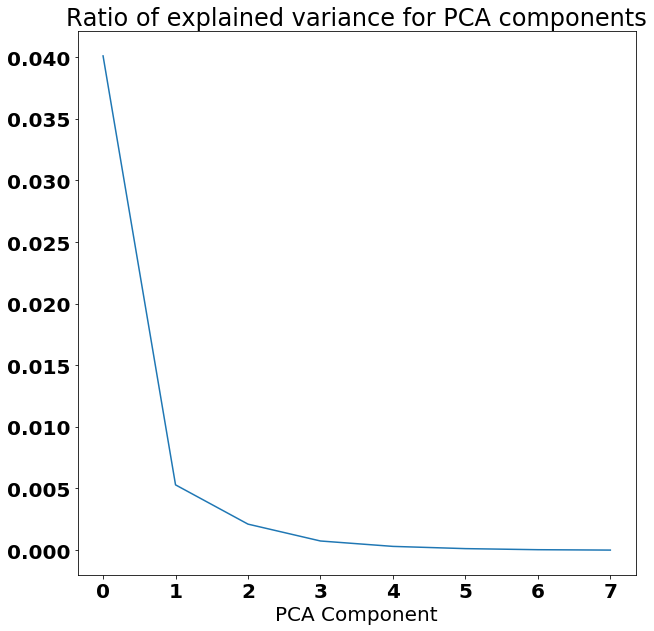

In [91]:
plt.rcParams['figure.figsize'] = [10, 10]
font={'size': 20, 'weight':'heavy'}
plt.rc('font', **font)

plt.plot(np.sum(pca.explained_variance_ratio_)-np.cumsum(pca.explained_variance_ratio_))
plt.title('Ratio of explained variance for PCA components')
plt.xlabel('PCA Component')
plt.show()

In [36]:
data[1].keys()

dict_keys(['ech', 'gasB', 'gasC', 'gasD', 'gasE', 'pfx1', 'pfx2', 'shotnum', 'temp', 'thomson_temp_EFIT01', 'thomson_temp_EFITRT1', 'time'])

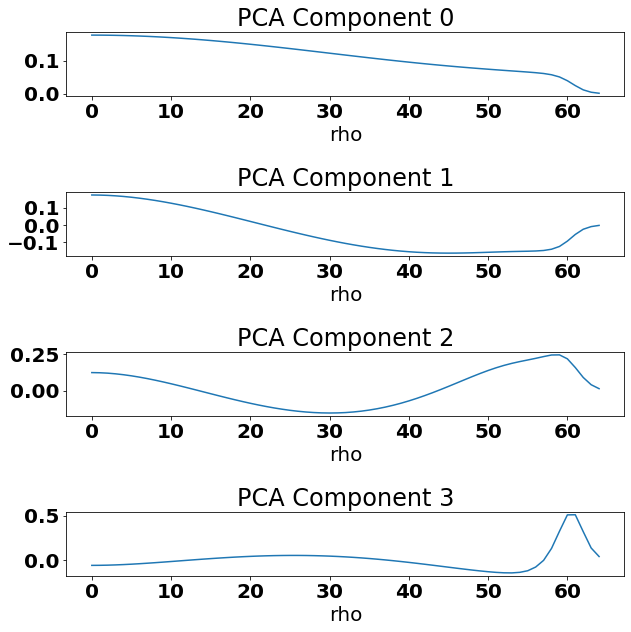

In [94]:
plt.rcParams['figure.figsize'] = [10, 10]
font={'size': 20, 'weight':'heavy'}
plt.rc('font', **font)

fig=plt.figure()
num_plots=min(9,len(pca.components_))
for i in range(num_plots):
    ax=fig.add_subplot('{}{}{}'.format(num_plots,1,i+1))
    ax.plot(pca.components_[i])
    ax.set_title('PCA Component {}'.format(i))
    ax.set_xlabel('rho')
plt.xlabel('rho',fontsize=20)
plt.subplots_adjust(hspace=1.5)

In [103]:
pca_data=pca.transform(pre_pca_normalized)

In [104]:
thomson_pca=pca.transform(data[0]['thomson_temp_EFITRT1'][:,-1,:])

Index 464157



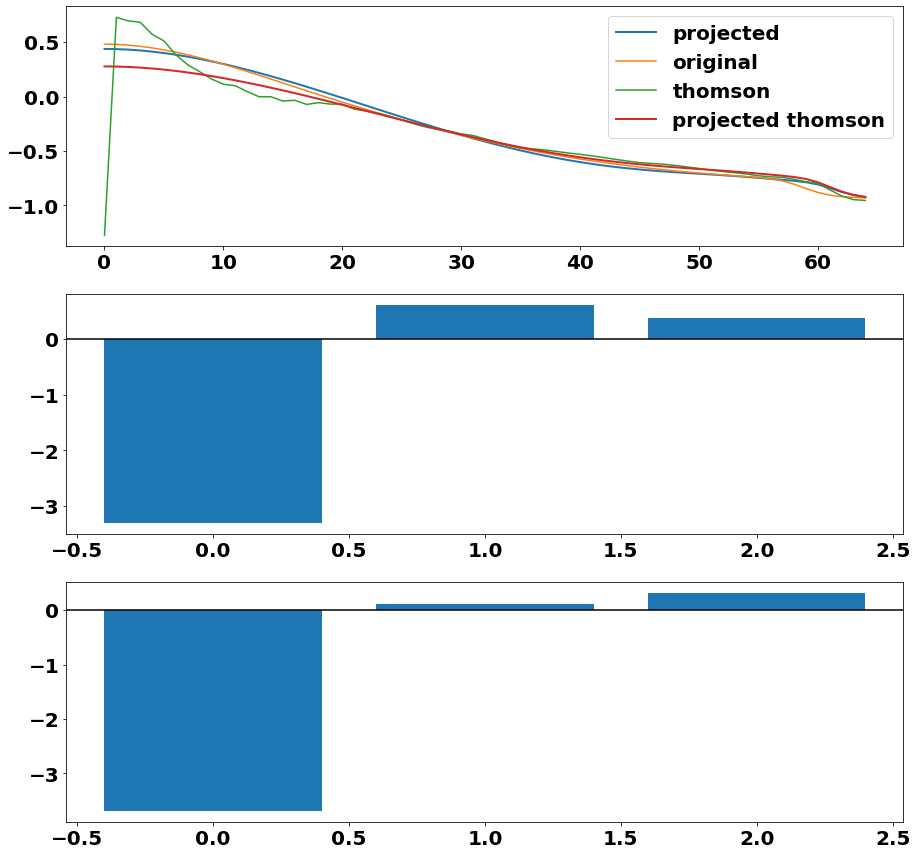

In [105]:
plt.rcParams['figure.figsize'] = [15, 15]
font={'size': 20, 'weight':'heavy'}
plt.rc('font', **font)

fig=plt.figure()
ind=np.random.choice(len(pca_data))
ax=fig.add_subplot('311')
ax.plot(pca.inverse_transform(pca_data[ind]),label='projected',linewidth=2)
ax.plot(pre_pca_normalized[ind],label='original')
ax.plot(data[0]['thomson_temp_EFITRT1'][ind,-1,:],label='thomson')
ax.plot(pca.inverse_transform(thomson_pca[ind]),label='projected thomson',linewidth=2)
ax.legend()

ax=fig.add_subplot('312')
ax.bar([i for i  in range(len(pca_data[ind]))],pca_data[ind])
ax.axhline(0,color='k')

ax=fig.add_subplot('313')
ax.bar([i for i  in range(len(thomson_pca[ind]))],thomson_pca[ind])
ax.axhline(0,color='k')

print('Index {}\n'.format(ind))

plt.show()